In [1]:
import pandas as pd
import simplekml
from datetime import datetime
import csv
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
df_andenes_ute = pd.read_csv('logs/cansat_real.txt', sep=',')
df_andenes_inne = pd.read_csv('logs/cansat_launch.txt', sep=',')
df_spaceport = pd.read_csv('logs/log.txt', sep=',')
print(df_andenes_ute)

     elapsed_time    id      time     alt        lat        lng   pressure  \
0          0:2:33   945   14:6:23    83.4  69.295898  16.029207  100392.11   
1          0:2:35   946   14:6:25    87.6  69.295914  16.029295  100245.01   
2          0:2:40   948   14:6:30    98.8  69.295929  16.029293   99981.00   
3          0:2:42   949   14:6:32   106.6  69.295860  16.029194   99887.51   
4          0:2:46   951   14:6:36   116.4  69.295937  16.028976   99697.45   
...           ...   ...       ...     ...        ...        ...        ...   
1575      1:19:33  3066  15:23:23  4120.1  69.606560  15.663271   59232.73   
1576      1:19:39  3069  15:23:29  4032.2  69.607231  15.663172   59871.40   
1577      1:19:41  3070  15:23:31  4007.6  69.607452  15.663124   60090.14   
1578      1:19:44  3071  15:23:33  3982.7  69.607674  15.663103   60322.62   
1579      1:19:52  3075  15:23:42  3871.7  69.608627  15.663056   61217.25   

           ohm      hum     co2     temp  rssi  
0     22618.76

In [2]:

df_merged = pd.merge(df_spaceport, df_andenes_ute, on=['elapsed_time','id','time','alt','lat','lng','pressure','ohm','hum','co2','temp','rssi'], how='outer')  # Merge df1 and df2
df_merged = pd.merge(df_merged, df_andenes_inne, on=['elapsed_time','id','time','alt','lat','lng','pressure','ohm','hum','co2','temp','rssi'], how='outer')  # Merge the result with df3

# The "how='outer'" parameter ensures that all unique values from each dataset are included in the merged dataset without overlapping the same values

df_merged = df_merged.sort_values('id') 

df_merged.drop_duplicates(subset=['id'], inplace=True) # Deletes the duplicate id's so we dont get duplicate values

# Saves the merged dataset to a txt file
# df_merged.to_csv('merged_data.txt', index=False, sep=',')


In [3]:
# NTC Material constants
A1 = 3.354016e-3
B1 = 2.569850e-4
C1 = 2.620131e-6
D1 = 6.383091e-8
# Logarithmic values of resistance
log_NTC = np.log(df_merged['ohm']/10000)
# Steinhart and Hart Equation
df_merged['temp_ntc'] = (1 / (A1 + B1 * log_NTC + C1 * log_NTC * log_NTC + D1 * log_NTC * log_NTC * log_NTC)) - 273.15

Packets lost at Spaceport:212
Packets lost at Andenes inside:129
Packets lost at Andenes outside:359
Packets lots in total: 54
Max altitude: 18534.290602290628 meters


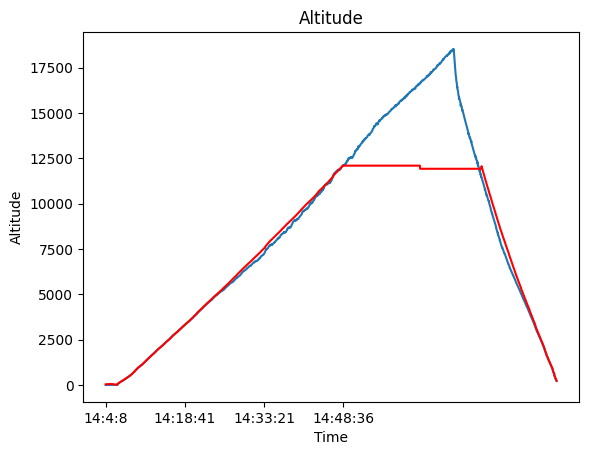

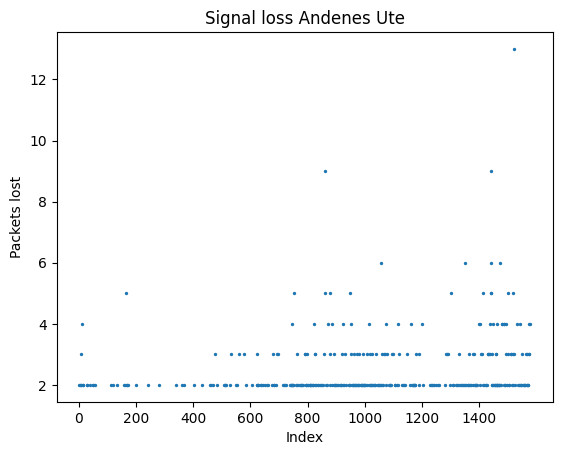

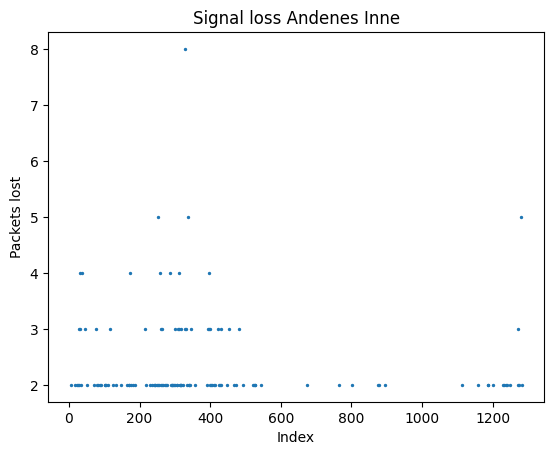

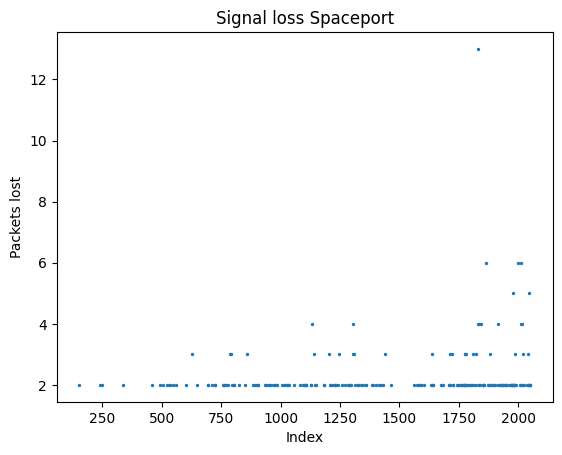

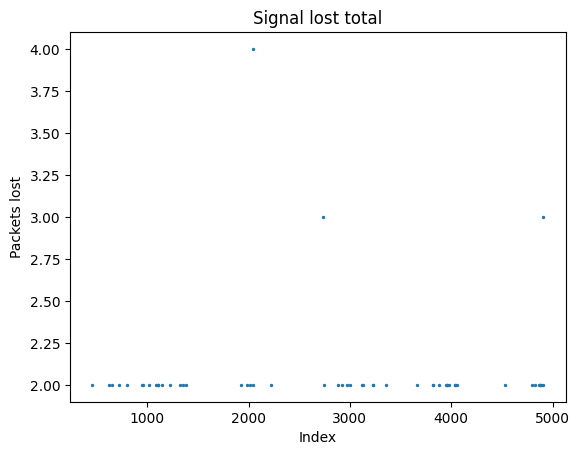

In [4]:

# Finds the difference between the ID difference to find difference between ID's
df_andenes_ute['loss'] = df_andenes_ute['id'].diff()
df_andenes_inne['loss'] = df_andenes_inne['id'].diff()
df_spaceport['loss'] = df_spaceport['id'].diff()
df_merged['loss'] = df_merged['id'].diff()

# Removes all 1 values to find where packages was lost
loss_au = df_andenes_ute[df_andenes_ute['loss'] > 1]
loss_ai = df_andenes_inne[df_andenes_inne['loss'] > 1]
loss_sp = df_spaceport[df_spaceport['loss'] > 1]
loss = df_merged[df_merged['loss'] > 1]

# Prints number indexes for each datasets loss. The actual packages lost is a little higher, but it show how many times we lost packages
print(f"Packets lost at Spaceport:{len(loss_sp.index)}")
print(f"Packets lost at Andenes inside:{len(loss_ai.index)}")
print(f"Packets lost at Andenes outside:{len(loss_au.index)}")
print(f"Packets lots in total: {len(loss.index)}")


R = 8.31446261815324 # Universal gas constant
T0 = df_merged['temp_ntc'] + 273.15 # temp in Kelvin
g = 9.80665 # Gravitational constant
M = 0.0289644 # molar mass of Earth's air
P0 = 101033.66 # Pressure at ground level
P = df_merged['pressure'] # pressure in Pa

df_merged['altitude'] = (R*T0/(g*M))*np.log(P0/P) # barometric altimeter equation

print(f"Max altitude: {df_merged['altitude'].max()} meters")

# Plot the calculated altitude vs GPS altitude
plt.xticks(np.arange(0,1597, 400)) 
plt.plot(df_merged['time'], df_merged['altitude'])
plt.plot(df_merged['time'], df_merged['alt'], 'r')
plt.xlabel('Time')
plt.ylabel('Altitude')
plt.title('Altitude')
plt.show()

# Plots signal loss at Andenes outside
plt.xticks(np.arange(0,1597, 200))
plt.scatter(loss_au.index, loss_au['loss'], s=2)
plt.xlabel('Index')
plt.ylabel('Packets lost')
plt.title('Signal loss Andenes Ute')
plt.show()

# Plots signal loss at Andenes inside
plt.scatter(loss_ai.index, loss_ai['loss'], s=2)
plt.xlabel('Index')
plt.ylabel('Packets lost')
plt.title('Signal loss Andenes Inne')
plt.show()

# Plots signal loss at Andøya Space
plt.scatter(loss_sp.index, loss_sp['loss'], s=2)
plt.xlabel('Index')
plt.ylabel('Packets lost')
plt.title('Signal loss Spaceport')
plt.show()

# Plots total signal loss
plt.scatter(loss.index, loss['loss'], s=2)
plt.xlabel('Index')
plt.ylabel('Packets lost')
plt.title('Signal lost total')
plt.show()


0       480.35
1       480.89
2       480.81
3       481.24
4       481.24
         ...  
4922    308.83
4923    308.83
2053    302.49
2054    302.62
2055    300.42
Name: co2, Length: 2277, dtype: float64


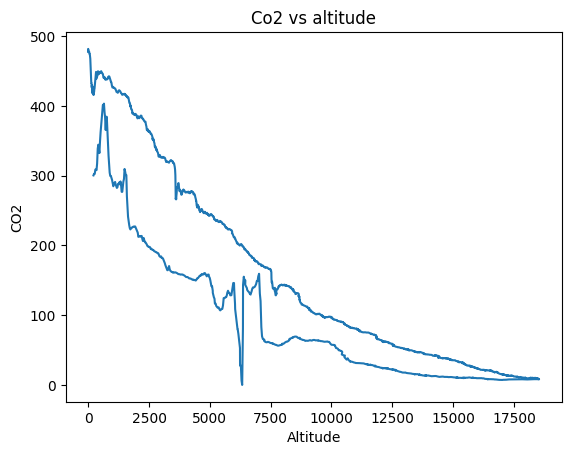

In [5]:
# Plot the CO2 vs altitude
print(df_merged['co2'])
plt.plot(df_merged['altitude'], df_merged['co2'])
plt.xlabel('Altitude')
plt.ylabel('CO2')
plt.title('Co2 vs altitude')
plt.show()


In [6]:
# start_point = df_merged.iloc[0]  # Start is the first row
# max_altitude_index = df_merged['altitude'].idxmax() 
# max_altitude_point = df_merged.loc[max_altitude_index]
# end_point = df_merged.iloc[-1]  # End is the last row

# selected_points = pd.DataFrame([start_point, max_altitude_point, end_point])

# kml = simplekml.Kml()
# # Create a LineString with all points to show the trajectory
# linestring = kml.newlinestring(name="Full Trajectory")
# linestring.coords = [(lon, lat, alt) for lat, lon, alt in zip(df_merged['lat'], df_merged['lng'], df_merged['altitude'])]
# linestring.altitudemode = simplekml.AltitudeMode.absolute
# linestring.extrude = 1  # Extend line to the ground
# linestring.style.linestyle.color = '25525500'  # Opaque red, aabbggrr format

# for point, label in zip([start_point, max_altitude_point, end_point], ["Start", "Max Altitude", "End"]):
#     pnt = kml.newpoint(name=label, coords=[(point['lng'], point['lat'], point['altitude'])])
#     pnt.altitudemode = simplekml.AltitudeMode.absolute
#     #pnt.extrude = 1

# kml.save('test.kml')